# On Deep Learning-Based Channel Decoding

If you want to cite this notebook, please use the following bibtext entry:

    @article{nn-decoding,
      title={On Deep Learning-Based Channel Decoding},
      author={Tobias Gruber and
              Sebastian Cammerer and
              Jakob Hoydis and
              Stephan ten Brink}
      journal={CoRR}
      year={2017}
      url= {http://arxiv.org/abs/1701.07738}
    }

Running this example requires Keras installed with the Theano backend. For GPU support nvidia-docker is required. A Dockerfile is provided to employ this setup quickly.

Our simulation setup was inspired by material from http://radioml.org.


In [1]:
from os import environ
environ['KERAS_BACKEND']='tensorflow'

In [2]:
import numpy as np
from keras.models import Sequential
from keras.layers.core import Dense, Lambda
from keras import backend as K
import matplotlib.pyplot as plt
import datetime
import timeit
import pandas as pd
%matplotlib inline
print(K.backend())

Using TensorFlow backend.


tensorflow


In [3]:
import tensorflow as tf
print(tf.test.is_gpu_available(cuda_only=True))
from tensorflow.python.client import device_lib
print(str(device_lib.list_local_devices()))

True
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13259342391653706294
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3173977294
locality {
  bus_id: 1
  links {
  }
}
incarnation: 12479477676018854590
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 960, pci bus id: 0000:01:00.0, compute capability: 5.2"
]


# Parameters

In [8]:
k = 8                       # number of information bits
N = 16                      # code length
train_SNR_Eb = 1            # training-Eb/No

# number of learning epochs (2^12, 2^14, etc)
nb_epochs = np.logspace(start=12,stop=18,num=int((18-12)/2)+1,base=2).astype('int32')
codes = ['random', 'polar']               # type of code ('random' or 'polar')
design = [128, 64, 32]                    # each list entry defines the number of nodes in a layer
batch_size = 256                          # size of batches for calculation the gradient
LLR = False                               # 'True' enables the log-likelihood-ratio layer
# https://keras.io/api/optimizers/
optimizers = ['sgd','rmsprop','adam','adadelta','adagrad','adamax','nadam']
loss = 'mse'                              # or 'binary_crossentropy'

train_SNR_Es = train_SNR_Eb + 10*np.log10(k/N)
train_sigma = np.sqrt(1/(2*10**(train_SNR_Es/10)))

[  4096  16384  65536 262144]


# Retrieve MAP results

import pathlib
import urllib.request

map_filename_prefix = f'map/{code}/'
map_filename_suffix = f'results_{code}_map_{N}_{k}.txt'
if pathlib.Path(map_filename_prefix+map_filename_suffix).exists():
    print(f'file {map_filename_prefix}-{map_filename_suffix} exists!')
else:
    pathlib.Path(map_filename_prefix).mkdir(parents=True, exist_ok=True)
    url = f'https://raw.githubusercontent.com/marcelovca90/DL-ChannelDecoding/master/notebooks/map/{code}/{map_filename_suffix}'
    urllib.request.urlretrieve(url, map_filename_prefix+map_filename_suffix)
    print(f'file {url} downloaded!')

# Define NN model

In [5]:
def modulateBPSK(x):
    return -2*x +1;

def addNoise(x, sigma):
    w = K.random_normal(K.shape(x), mean=0.0, stddev=sigma)
    return x + w

def ber(y_true, y_pred):
    return K.mean(K.not_equal(y_true, K.round(y_pred)))

def return_output_shape(input_shape):  
    return input_shape

def compose_model(layers):
    model = Sequential()
    for layer in layers:
        model.add(layer)
    return model

def log_likelihood_ratio(x, sigma):
    return 2*x/np.float32(sigma**2)

# https://pt.coredump.biz/questions/45328314/kerastensorflow-adding-a-new-metric-with-an-inequality
def errors(y_true, y_pred):
    return K.sum(K.cast(K.not_equal(y_true, K.round(y_pred)),'float32'))

# Data Generation

In [6]:
def half_adder(a,b):
    s = a ^ b
    c = a & b
    return s,c

def full_adder(a,b,c):
    s = (a ^ b) ^ c
    c = (a & b) | (c & (a ^ b))
    return s,c

def add_bool(a,b):
    if len(a) != len(b):
        raise ValueError('arrays with different length')
    k = len(a)
    s = np.zeros(k,dtype=bool)
    c = False
    for i in reversed(range(0,k)):
        s[i], c = full_adder(a[i],b[i],c)    
    if c:
        warnings.warn("Addition overflow!")
    return s

def inc_bool(a):
    k = len(a)
    increment = np.hstack((np.zeros(k-1,dtype=bool), np.ones(1,dtype=bool)))
    a = add_bool(a,increment)
    return a

def bitrevorder(x):
    m = np.amax(x)
    n = np.ceil(np.log2(m)).astype(int)
    for i in range(0,len(x)):
        x[i] = int('{:0{n}b}'.format(x[i],n=n)[::-1],2)  
    return x

def int2bin(x,N):
    if isinstance(x, list) or isinstance(x, np.ndarray):
        binary = np.zeros((len(x),N),dtype='bool')
        for i in range(0,len(x)):
            binary[i] = np.array([int(j) for j in bin(x[i])[2:].zfill(N)])
    else:
        binary = np.array([int(j) for j in bin(x)[2:].zfill(N)],dtype=bool)
    
    return binary

def bin2int(b):
    if isinstance(b[0], list):
        integer = np.zeros((len(b),),dtype=int)
        for i in range(0,len(b)):
            out = 0
            for bit in b[i]:
                out = (out << 1) | bit
            integer[i] = out
    elif isinstance(b, np.ndarray):
        if len(b.shape) == 1:
            out = 0
            for bit in b:
                out = (out << 1) | bit
            integer = out     
        else:
            integer = np.zeros((b.shape[0],),dtype=int)
            for i in range(0,b.shape[0]):
                out = 0
                for bit in b[i]:
                    out = (out << 1) | bit
                integer[i] = out
        
    return integer

def polar_design_awgn(N, k, design_snr_dB):  
        
    S = 10**(design_snr_dB/10)
    z0 = np.zeros(N)

    z0[0] = np.exp(-S)
    for j in range(1,int(np.log2(N))+1):
        u = 2**j
        for t in range(0,int(u/2)):
            T = z0[t]
            z0[t] = 2*T - T**2     # upper channel
            z0[int(u/2)+t] = T**2  # lower channel
        
    # sort into increasing order
    idx = np.argsort(z0)
        
    # select k best channels
    idx = np.sort(bitrevorder(idx[0:k]))
    
    A = np.zeros(N, dtype=bool)
    A[idx] = True
        
    return A

def polar_transform_iter(u):

    N = len(u)
    n = 1
    x = np.copy(u)
    stages = np.log2(N).astype(int)
    for s in range(0,stages):
        i = 0
        while i < N:
            for j in range(0,n):
                idx = i+j
                x[idx] = x[idx] ^ x[idx+n]
            i=i+2*n
        n=2*n
    return x

# Prepare, Train and Test Neural Network

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
modulator (Lambda)           (None, 16)                0         
_________________________________________________________________
noise (Lambda)               (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               2176      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 264       
Total params: 12,776
Trainable params: 

2021-06-16 02:50:57.256550	random @ adam @ Mep=2^12 fit finished (took 15.224 [s]).
2021-06-16 02:50:57.256550	test @ sigmas=[1.         0.97696533 0.95393067 0.930896   0.90786133 0.88482666
 0.861792   0.83875733 0.81572266 0.792688   0.76965333 0.74661866
 0.72358399 0.70054933 0.67751466 0.65447999 0.63144533 0.60841066
 0.58537599 0.56234133]
2021-06-16 02:50:58.228016	test @ sigma[0]=1.0	nb_bits=800000	nb_errors=199400
2021-06-16 02:50:59.115037	test @ sigma[1]=0.9769653329047552	nb_bits=800000	nb_errors=193400
2021-06-16 02:51:00.033065	test @ sigma[2]=0.9539306658095105	nb_bits=800000	nb_errors=187800
2021-06-16 02:51:01.204859	test @ sigma[3]=0.9308959987142656	nb_bits=800000	nb_errors=181200
2021-06-16 02:51:02.271088	test @ sigma[4]=0.9078613316190208	nb_bits=800000	nb_errors=174500
2021-06-16 02:51:03.245104	test @ sigma[5]=0.8848266645237761	nb_bits=800000	nb_errors=168300
2021-06-16 02:51:04.284102	test @ sigma[6]=0.8617919974285313	nb_bits=800000	nb_errors=159900
2021-06

2021-06-16 02:52:19.976685	test @ sigma[11]=0.7466186619523074	nb_bits=800000	nb_errors=152000
2021-06-16 02:52:20.900696	test @ sigma[12]=0.7235839948570626	nb_bits=800000	nb_errors=145000
2021-06-16 02:52:21.754061	test @ sigma[13]=0.7005493277618178	nb_bits=800000	nb_errors=137500
2021-06-16 02:52:22.614153	test @ sigma[14]=0.677514660666573	nb_bits=800000	nb_errors=130400
2021-06-16 02:52:23.484621	test @ sigma[15]=0.6544799935713281	nb_bits=800000	nb_errors=123800
2021-06-16 02:52:24.356443	test @ sigma[16]=0.6314453264760834	nb_bits=800000	nb_errors=116500
2021-06-16 02:52:25.232046	test @ sigma[17]=0.6084106593808387	nb_bits=800000	nb_errors=110100
2021-06-16 02:52:26.101134	test @ sigma[18]=0.5853759922855939	nb_bits=800000	nb_errors=101900
2021-06-16 02:52:26.968126	test @ sigma[19]=0.5623413251903491	nb_bits=800000	nb_errors=93800
Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Par

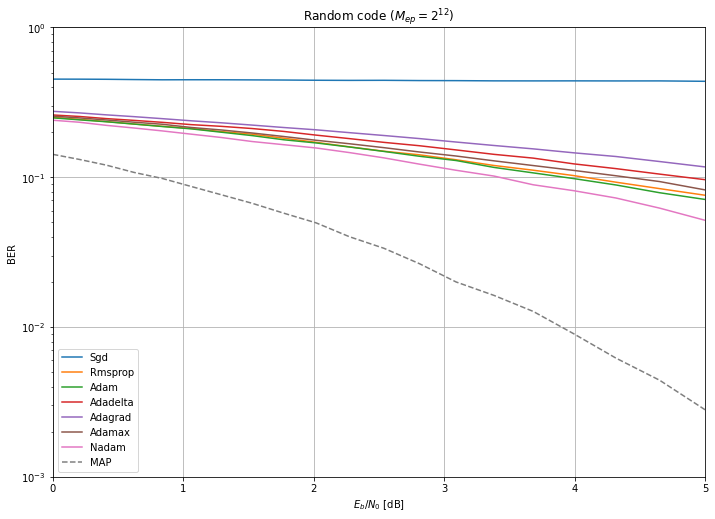

Model: "sequential_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
modulator (Lambda)           (None, 16)                0         
_________________________________________________________________
noise (Lambda)               (None, 16)                0         
_________________________________________________________________
dense_29 (Dense)             (None, 128)               2176      
_________________________________________________________________
dense_30 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_31 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_32 (Dense)             (None, 8)                 264       
Total params: 12,776
Trainable params: 12,776
Non-trainable params: 0
_________________________________________________

2021-06-16 02:55:56.793618	test @ sigma[0]=1.0	nb_bits=800000	nb_errors=130400
2021-06-16 02:55:58.933457	test @ sigma[1]=0.9769653329047552	nb_bits=800000	nb_errors=122500
2021-06-16 02:56:01.100294	test @ sigma[2]=0.9539306658095105	nb_bits=800000	nb_errors=114300
2021-06-16 02:56:03.361297	test @ sigma[3]=0.9308959987142656	nb_bits=800000	nb_errors=107600
2021-06-16 02:56:05.708201	test @ sigma[4]=0.9078613316190208	nb_bits=800000	nb_errors=100100
2021-06-16 02:56:07.940050	test @ sigma[5]=0.8848266645237761	nb_bits=800000	nb_errors=91200
2021-06-16 02:56:10.127424	test @ sigma[6]=0.8617919974285313	nb_bits=800000	nb_errors=84200
2021-06-16 02:56:12.327152	test @ sigma[7]=0.8387573303332865	nb_bits=800000	nb_errors=76300
2021-06-16 02:56:14.513593	test @ sigma[8]=0.8157226632380417	nb_bits=800000	nb_errors=67500
2021-06-16 02:56:16.717142	test @ sigma[9]=0.792687996142797	nb_bits=800000	nb_errors=61200
2021-06-16 02:56:18.976139	test @ sigma[10]=0.7696533290475521	nb_bits=800000	nb_

2021-06-16 02:58:37.038641	test @ sigma[15]=0.6544799935713281	nb_bits=800000	nb_errors=72100
2021-06-16 02:58:39.279129	test @ sigma[16]=0.6314453264760834	nb_bits=800000	nb_errors=66100
2021-06-16 02:58:41.501941	test @ sigma[17]=0.6084106593808387	nb_bits=800000	nb_errors=60700
2021-06-16 02:58:43.687052	test @ sigma[18]=0.5853759922855939	nb_bits=800000	nb_errors=54400
2021-06-16 02:58:45.854597	test @ sigma[19]=0.5623413251903491	nb_bits=800000	nb_errors=50500
Model: "sequential_65"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
modulator (Lambda)           (None, 16)                0         
_________________________________________________________________
noise (Lambda)               (None, 16)                0         
_________________________________________________________________
dense_49 (Dense)             (None, 128)               2176      
_____________________________________________

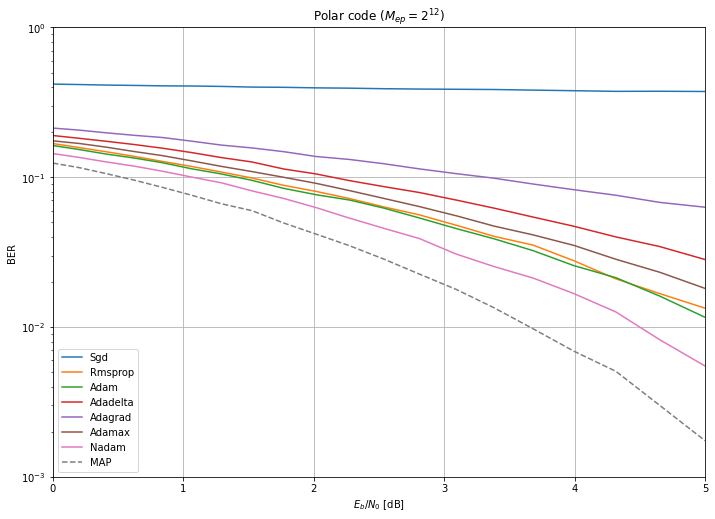

In [7]:
for code in codes:
    
    # Create all possible information words
    d = np.zeros((2**k,k),dtype=bool)
    for i in range(1,2**k):
        d[i]= inc_bool(d[i-1])

    # Create sets of all possible codewords (codebook)
    if code == 'polar':   

        A = polar_design_awgn(N, k, design_snr_dB=0)  # logical vector indicating the nonfrozen bit locations 
        x = np.zeros((2**k, N),dtype=bool)
        u = np.zeros((2**k, N),dtype=bool)
        u[:,A] = d

        for i in range(0,2**k):
            x[i] = polar_transform_iter(u[i])

    elif code == 'random':

        np.random.seed(4267)   # for a 16bit Random Code (r=0.5) with Hamming distance >= 2
        x = np.random.randint(0,2,size=(2**k,N), dtype=bool)

    for nb_epoch in nb_epochs:
        
        # https://stackoverflow.com/questions/15571267/python-a4-size-for-a-plot
        fig = plt.figure(figsize=(11.69,8.27))

        for optimizer in optimizers:

            ###################
            # Define NN model #
            ###################

            # Define modulator
            modulator_layers = [Lambda(modulateBPSK, 
                                      input_shape=(N,), output_shape=return_output_shape, name="modulator")]
            modulator = compose_model(modulator_layers)
            modulator.compile(optimizer=optimizer, loss=loss)

            # Define noise
            noise_layers = [Lambda(addNoise, arguments={'sigma':train_sigma}, 
                                   input_shape=(N,), output_shape=return_output_shape, name="noise")]
            noise = compose_model(noise_layers)
            noise.compile(optimizer=optimizer, loss=loss)

            # Define LLR
            llr_layers = [Lambda(log_likelihood_ratio, arguments={'sigma':train_sigma}, 
                                 input_shape=(N,), output_shape=return_output_shape, name="LLR")]
            llr = compose_model(llr_layers)
            llr.compile(optimizer=optimizer, loss=loss)

            # Define decoder 
            decoder_layers = [Dense(design[0], activation='relu', input_shape=(N,))]
            for i in range(1,len(design)):
                decoder_layers.append(Dense(design[i], activation='relu'))
            decoder_layers.append(Dense(k, activation='sigmoid'))
            decoder = compose_model(decoder_layers)
            decoder.compile(optimizer=optimizer, loss=loss, metrics=[errors])

            # Define model
            if LLR:
                model_layers = modulator_layers + noise_layers + llr_layers + decoder_layers
            else:
                model_layers = modulator_layers + noise_layers + decoder_layers
            model = compose_model(model_layers)
            model.compile(optimizer=optimizer, loss=loss, metrics=[ber])

            ############
            # Train NN #
            ############    

            model.summary()

            start_time = timeit.default_timer()
            print(f'{datetime.datetime.now()}\t{code} @ {optimizer} @ Mep=2^{int(np.log2(nb_epoch))} fit started.')
            history = model.fit(x, d, batch_size=batch_size, epochs=nb_epoch, verbose=0, shuffle=True)
            end_time = timeit.default_timer()
            print(f'{datetime.datetime.now()}\t{code} @ {optimizer} @ Mep=2^{int(np.log2(nb_epoch))} fit finished (took {end_time-start_time:1.3f} [s]).')

            ###########
            # Test NN #
            ###########

            test_batch = 1000  
            num_words = 100000      # multiple of test_batch

            SNR_dB_start_Eb = 0
            SNR_dB_stop_Eb = 5
            SNR_points = 20

            SNR_dB_start_Es = SNR_dB_start_Eb + 10*np.log10(k/N)
            SNR_dB_stop_Es = SNR_dB_stop_Eb + 10*np.log10(k/N)

            sigma_start = np.sqrt(1/(2*10**(SNR_dB_start_Es/10)))
            sigma_stop = np.sqrt(1/(2*10**(SNR_dB_stop_Es/10)))

            sigmas = np.linspace(sigma_start, sigma_stop, SNR_points)
            print(f'{datetime.datetime.now()}\ttest @ sigmas={sigmas}')

            nb_errors = np.zeros(len(sigmas),dtype=int)
            nb_bits = np.zeros(len(sigmas),dtype=int)

            for i in range(0,len(sigmas)):

                for ii in range(0,np.round(num_words/test_batch).astype(int)):

                    # Source
                    np.random.seed(0)
                    d_test = np.random.randint(0,2,size=(test_batch,k)) 

                    # Encoder
                    if code == 'polar':
                        x_test = np.zeros((test_batch, N),dtype=bool)
                        u_test = np.zeros((test_batch, N),dtype=bool)
                        u_test[:,A] = d_test

                        for iii in range(0,test_batch):
                            x_test[iii] = polar_transform_iter(u_test[iii])

                    elif code == 'random':
                        x_test = np.zeros((test_batch, N),dtype=bool)
                        for iii in range(0,test_batch):
                            x_test[iii] = x[bin2int(d_test[iii])]

                    # Modulator (BPSK)
                    s_test = -2*x_test + 1

                    # Channel (AWGN)
                    y_test = s_test + sigmas[i]*np.random.standard_normal(s_test.shape)

                    if LLR:
                        y_test = 2*y_test/(sigmas[i]**2)

                    # Decoder
                    nb_errors[i] += decoder.evaluate(y_test, d_test, batch_size=test_batch, verbose=0)[1]
                    nb_bits[i] += d_test.size

                print(f'{datetime.datetime.now()}\ttest @ sigma[{i}]={sigmas[i]}\tnb_bits={nb_bits[i]}\tnb_errors={nb_errors[i]}')

            ############
            # Load MAP #
            ############

            result_map = np.loadtxt('map/{}/results_{}_map_{}_{}.txt'.format(code,code,N,k), delimiter=', ')
            sigmas_map = result_map[:,0]
            nb_bits_map = result_map[:,1]
            nb_errors_map = result_map[:,2]

            #######################
            # Plot Bit-Error-Rate #
            #######################

            legend = []

            x_nn = 10*np.log10(1/(2*sigmas**2)) - 10*np.log10(k/N)
            y_nn = nb_errors/nb_bits
            #print(f'x_nn = {x_nn}')
            #print(f'y_nn = {y_nn}')
            #plt.plot(x_nn, y_nn)
            #legend.append('NN') 

            x_map = 10*np.log10(1/(2*sigmas_map**2)) - 10*np.log10(k/N)
            y_map = nb_errors_map/nb_bits_map
            #print(f'x_map = {x_map}')
            #print(f'y_map = {y_map}')
            #plt.plot(x_map, y_map)
            #legend.append('MAP')

            ##########################
            # Save data for plotting #
            ##########################

            df_filename = f'code={code}_epochs=2^{int(np.log2(nb_epoch))}_optimizer={optimizer}.csv'
            data = np.c_[x_nn,y_nn,x_map,y_map]
            names = ['x_nn','y_nn','x_map','y_map']
            pd.DataFrame(data,columns=names).to_csv(df_filename,index=False)
            #print(f'data = {data}')

            plt.plot(x_nn, y_nn, label=optimizer.capitalize())

        ############
        # Figure 3 #
        ############
        plt.plot(x_map, y_map, label='MAP', linestyle='dashed')
        plt.grid()
        plt.legend()
        plt.yscale('log')
        plt.title(code.capitalize() + ' code ($M_{ep}=2^{' + str(int(np.log2(nb_epoch))) + '})$')
        plt.xlabel('$E_b/N_0$ [dB]')
        plt.ylabel('BER')
        plt.xlim(0, 5)
        plt.ylim(1e-3, 1e0)
        plt.savefig(f'code={code}_epochs=2^{int(np.log2(nb_epoch))}.png')
        plt.show()